# This is the ML Part

So first of all the files need to be loaded from the Data Base

Following is the Calculation of the Influence Score, that needs a swell value. This has to be done by looking up the numbers calculated. 

Third is choosing the number of Clusters

and finally I can Score the Offer types against the Clusters and see how they differ.

In [1]:
import numpy as np
import pandas as pd
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from kmodes.kprototypes import KPrototypes



from scipy import interpolate

import sqlite3
from sqlalchemy import create_engine

In [2]:
engine = create_engine('sqlite:///data/data.db')


portfolio = pd.read_sql_table ('portfolio', engine)
profile = pd.read_sql_table ('profiles', engine)


In [3]:
received_reaction_matrix = pd.read_sql_table ('received_reaction_matrix', engine)
transcript = pd.read_sql_table ('transcript', engine)

In [94]:
transcript.head()

,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth
index,,,,,,,,,,,,,,,,,,,,,
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0,0,0,0,0,0,...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,bogo,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0,1,0,0,0,0,...,0,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,discount,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0,0,0,1,0,0,...,0,0,0,0,2906b810c7d4411798c6938adc9daaa5,168,discount,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0,0,0,0,0,0,...,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,240,discount,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0,0,0,0,0,1,...,0,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,120,bogo,0,0,0


In [4]:
# since I had to save everything as string-type, I do have to reformat the types

transcript ['time in hours'] = transcript['time in hours'].astype (int)
transcript ['amount'] = transcript['amount'].astype (float)
transcript ['count'] = transcript['count'].astype (int)
transcript ['expiration'] = transcript['expiration'].astype (int)
transcript ['DayOfWeek'] = transcript['DayOfWeek'].astype (int)
transcript ['WeekOfMonth'] = transcript['WeekOfMonth'].astype (int)
transcript ['DayOfMonth'] = transcript['DayOfMonth'].astype (int)

received_reaction_matrix ['time in hours'] = received_reaction_matrix['time in hours'].astype (int)
received_reaction_matrix ['amount'] = received_reaction_matrix['amount'].astype (float)
received_reaction_matrix ['count'] = received_reaction_matrix['count'].astype (int)
received_reaction_matrix ['expiration'] = received_reaction_matrix['expiration'].astype (int)
received_reaction_matrix ['DayOfWeek'] = received_reaction_matrix['DayOfWeek'].astype (int)
received_reaction_matrix ['WeekOfMonth'] = received_reaction_matrix['WeekOfMonth'].astype (int)
received_reaction_matrix ['DayOfMonth'] = received_reaction_matrix['DayOfMonth'].astype (int)
received_reaction_matrix ['viewed_yn'] = received_reaction_matrix ['viewed_yn'].astype (int)
received_reaction_matrix ['viewtoexpire'] = received_reaction_matrix ['viewtoexpire'].astype (int)
received_reaction_matrix ['completed_yn'] = received_reaction_matrix ['completed_yn'].astype (int)
received_reaction_matrix ['compacttime'] = received_reaction_matrix ['compacttime'].astype (int)
received_reaction_matrix ['completed_yn_unknown'] = received_reaction_matrix ['completed_yn_unknown'].astype (int)
received_reaction_matrix ['index_received'] = received_reaction_matrix ['index_received'].astype (int)
received_reaction_matrix ['index_completed'] = received_reaction_matrix ['index_completed'].astype (int)
received_reaction_matrix ['index_viewed'] = received_reaction_matrix ['index_viewed'].astype (int)
received_reaction_matrix ['visits_count'] = received_reaction_matrix ['visits_count'].astype (int)

transcript = transcript.set_index ('index')
received_reaction_matrix = received_reaction_matrix
received_reaction_matrix.rename (columns = {'person_x': 'person', 'offer_id_x': 'offer_id'}, inplace = True)

# x.1 Functions

In [5]:
def split_on_event (data):

    '''
        Spliting the data set for better performance

    '''

    received = data [data ['event'] == 'offer received']

    viewed = data [data ['event'] == 'offer viewed']

    completed = data [data ['event'] == 'offer completed']

    transactions = data [data ['event'] == 'transaction']

    return received, viewed, completed, transactions


def offer_per_person (offer_type):
    
    reactions = received_reaction_matrix [received_reaction_matrix ['offer_type'] == offer_type]
    offers = received [received ['offer_type'] == offer_type].groupby ('person')['DayOfMonth'].value_counts ().to_frame().unstack().fillna (0)

    auswahl = ['viewed_yn', 'completed_yn',
           'completed_yn_unknown', 'visits_count']



    offers = offers.merge (reactions.groupby ('person_x')[auswahl].sum(), left_on = offers.index, 
                               right_on =reactions.groupby ('person_x')[auswahl].sum().index).sort_values ('visits_count', ascending = False)
    
    return offers

## Feature Design

Calculating the Influence Score



In [6]:
def get_offer_influence_score (i):
    
    '''
        The influence score of each offer should tell me,
        whether one is likely influenced or is not.
        
        5 terms where calculated
        
        This one is not in the ETL Part, because it can be adjusted and has to be discussed!
    
    '''
    
    try: 
        index_received = i
        person = received_reaction_matrix.set_index ('index_received').loc [i] ['person']
        offer_id = received_reaction_matrix.set_index ('index_received').loc [i] ['offer_id']
        m = received_reaction_matrix.set_index ('index_received').loc [i] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [i] ['index_completed']
        '''
            If an offer is not completed, there is no need to walk through those steps
        '''        
       
    except: 
        m = 0
        index_completed_return = -99
        
    
    try: 
        '''
            This term is for those customers, that are not part of the interquartile range,
            or for another reason are dropped.
            
        '''
        profile.set_index (['id']).loc [person]['count']
        m = received_reaction_matrix.set_index ('index_received').loc [i] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [i] ['index_completed']
    except:
        m = 0
        index_completed_return = -66
        
        '''
            code: -66 person not in profiles- dropped out maybe because of interquartile range
        '''

    
    if m == 1:
        
        '''
            Offer is seen and completed - calculating all the terms
        '''
            
        try: offers_pPerson_received = received [received ['person'] == person].count ()['person']
        except: offers_pPerson_received = 1
    
        try: offers_pPerson_viewed = viewed [viewed ['person'] == person].count ()['person']
        except: offers_pPerson_viewed = 0
            
        count_visits_each_customer = profile.set_index ('id').loc [person]['count']
    
        offer_amount =  portfolio.set_index ('id').loc [offer_id]['difficulty']
        offer_expiration = portfolio.set_index ('id').loc [offer_id]['duration']*24
        median_amount = profile.set_index ('id').loc [person]['50%']
    
        off_react_time = received_reaction_matrix.set_index ('index_received').loc [index_received] ['compacttime']
        view_to_expire = received_reaction_matrix.set_index ('index_received').loc [index_received] ['viewtoexpire']
    
        visits_count = received_reaction_matrix.set_index ('index_received').loc [index_received] ['visits_count']
        
        
        '''
            Term 1: intress in offers
            Offers viewed / Offers received
            
            setting a max for this value at 3
        '''
        try: 
            interest = offers_pPerson_viewed / (offers_pPerson_received * 0.75)
            interest = min (2, interest)
            interest = max (0, interest)
        except: freq_visits = 0
        
        
        '''
            Term 2: Percentage money more spent on the offer than median
            
            
        '''
        try: 
            overpay = (offer_amount / (median_amount * 0.66))
            overpay = min (2, overpay)
        except: overpay = 0
        

        
        
        
        '''
            Term 3: attractiveness
            
        '''
        try: 
            attractiveness = (view_to_expire * 0.25) / off_react_time 
            attractiveness = min (2, attractiveness)
            attractiveness = max (0, attractiveness)
        except: attractiveness = 0
       
    
    
        '''
            Term 4: fulfill_by_incident
            the more visits between recognizing the offer and completing it,
            the more unattracted those visits are by the offer itself.
            
        '''
        
        try: 
            fulfill_by_coincident = 1 / (1 * visits_count)
        except: 
            fulfill_by_coincident = 1
        fulfill_by_coincident = min (fulfill_by_coincident, 1)
    
    
        try: influence_score = interest * overpay * attractiveness
        except: influence_score = 0
    
        influence_score_vect = [interest, overpay, attractiveness]

    else: 
        fulfill_by_coincident = 0
        influence_score_vect = [0, 0, 0]
    
        
    return index_completed_return, fulfill_by_coincident, influence_score_vect

In [7]:
received, viewed, completed, transactions = split_on_event (transcript)

In [8]:
transactions.merge (received_reaction_matrix, left_index = True, right_index = True, how  = 'inner')
transactions.merge (received_reaction_matrix, 
                    left_index = True, right_index = True, how  = 'inner')['completed_yn_unknown'].value_counts()

0    21913
1     2417
Name: completed_yn_unknown, dtype: int64

In [9]:
transactions.merge (received_reaction_matrix, 
                    left_index = True, right_index = True, how  = 'inner')['offer_type_y'].value_counts()

bogo             9773
discount         9680
informational    4877
Name: offer_type_y, dtype: int64

## you can load the Vector later from the data base!!! 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## skip this part

In [11]:
# Calculating the Vector

influence_vect = []
influence_incident = []
influence_ind = []


offer_index = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].index


i = 0
stop = len (offer_index)

while i < stop:
    
    n = offer_index [i]
    
    index_completed, fulfill_by_coincident, influence_score_vect = get_offer_influence_score (n)
    influence_vect.append (influence_score_vect)
    influence_incident.append (fulfill_by_coincident)
    influence_ind.append (index_completed)
    
    
    print ('%.2f' % (i*100 / stop ), end = '\r')
    
    i += 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in long_scalars


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
influence_feature = pd.DataFrame (influence_ind, columns = ['index completed']).merge (
    pd.DataFrame (influence_vect).merge (pd.DataFrame (influence_incident, columns = ['coincidence_scal'])
                                         , left_index = True, right_index = True)
                                            , left_index = True, right_index = True)

influence_feature.to_sql ('influence_feature' ,engine, if_exists = 'replace')

In [ ]:
transactions.amount.describe()

## continue here and load the matrix 'influence feature'

In [10]:
influence_feature = pd.read_sql_table ('influence_feature', engine)

In [11]:
influence_ind = list (influence_feature['index completed'])

In [20]:
influence_vect = influence_feature [['0', '1', '2']]

In [21]:
pd.DataFrame(influence_vect).describe()

,0,1,2
count,23999.000000,23999.000000,23999.000000
mean,1.052257,0.988065,0.943451
std,0.363749,0.602254,0.786708
min,0.000000,0.000000,0.000000
25%,0.888889,0.562208,0.264706
50%,1.111111,0.822112,0.714286
75%,1.333333,1.400325,2.000000
max,1.333333,2.000000,2.000000


In [22]:
scalar2 = []

influence_vect = influence_feature [['0', '1', '2']]
influence_incident = influence_feature ['coincidence_scal']

i = 0
while i < len (influence_vect):
    y = 1
    for x in pd.DataFrame(influence_vect).iloc [i].sort_values (ascending = False)[:2]:
        y = y * x * pd.DataFrame (influence_incident).iloc [i]
    scalar2.append (y)
    
    print ('%.2f' % (i*100 / len (influence_vect) ), end = '\r')
    
    i += 1

In [23]:
pd.DataFrame(scalar2).describe()

,coincidence_scal
count,23999.000000
mean,1.501579
std,0.977163
min,0.000000
25%,0.706364
50%,1.359833
75%,2.222222
max,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca7e522ad0>]],
      dtype=object)

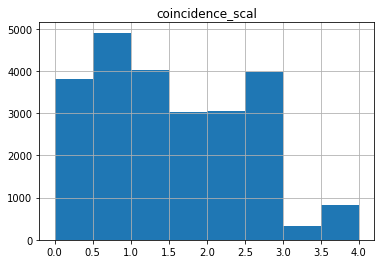

In [24]:
pd.DataFrame(scalar2).hist(bins = [0, 0.5, 1, 1.5, 2, 2.5 , 3, 3.5, 4])

In [25]:
influence_feature2 = influence_feature.merge (pd.DataFrame(scalar2)
                         , left_index = True, right_index = True).rename (
    columns = {'coincidence_scal_x': 'coincidence_scal', 'coincidence_scal_y': 'influence scalar'})

In [26]:
received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True).columns



Index(['index_received', 'index_x', 'person', 'event', 'time in hours',
       'amount', 'count', '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2', '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '5a8bc65990b245e5a138643cd4eb9837', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4', 'offer_id', 'expiration',
       'offer_type', 'DayOfWeek', 'WeekOfMonth', 'DayOfMonth', 'offer_id_y',
       'person_y', 'viewed_yn', 'viewtoexpire', 'completed_yn', 'compacttime',
       'completed_yn_unknown', 'index_viewed', 'index_completed',
       'visits_count', 'index_y', 'index completed', '0', '1', '2',
       'coincidence_scal', 'influence scalar'],
      dtype='object')

In [27]:
received_reaction_matrix ['completed_yn_unknown'].value_counts()

0    51166
1     5200
Name: completed_yn_unknown, dtype: int64

In [28]:
columns = ['index_received', 'index_x', 'person', 'event', 'time in hours',
       'amount', 'count', 'index_completed', 'index completed', '0', '1', '2',
       'coincidence_scal', 'influence scalar', 'offer_type', 'offer_id', 'expiration', 'viewed_yn', 'viewtoexpire', 'completed_yn', 'compacttime',
       'completed_yn_unknown', 'index_viewed', 'amount']

received_reaction_matrix2 = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True)[columns]




In [29]:
# merge 

# influence score
influence_feature2 = influence_feature.merge (pd.DataFrame(scalar2)
                         , left_index = True, right_index = True).rename (
    columns = {'coincidence_scal_x': 'coincidence_scal', 'coincidence_scal_y': 'influence scalar'})


# received reaction matrix
columns = ['index_completed', '0', '1', '2', 'index completed',
       'coincidence_scal', 'influence scalar']

received_reaction_matrix2 = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True)[columns]

received_reaction_matrix3 = received_reaction_matrix.set_index ('index_completed').merge (received_reaction_matrix2.set_index ('index_completed'), left_index = True, right_index = True, how = 'outer')



# transactions

columns = ['index_received',  'index completed',  '0', '1', '2',
       'coincidence_scal', 'influence scalar', 'offer_type', 'offer_id', 'expiration', 'viewed_yn', 'viewtoexpire', 'completed_yn',
       'compacttime', 'completed_yn_unknown', 'index_viewed']
transcript2 = transcript.merge(received_reaction_matrix3[columns], left_index = True, right_index = True, how = 'left').fillna (0)




# Clustering

I assume that different clusters react to different offer types better or worse


In [30]:
from sklearn import preprocessing

profiles_normalized = profile
Num_features= ['age', 'income', 'member_x_weeks']
profiles_normalized[Num_features]=preprocessing.MinMaxScaler().fit_transform(profiles_normalized[Num_features])

# set the data-types:

profiles_normalized ['gender'] = profiles_normalized.gender.astype (object)
profiles_normalized ['age'] = profiles_normalized.age.astype (float)
profiles_normalized ['id'] = profiles_normalized.id.astype (object)

profiles_normalized ['F'] = profiles_normalized.F.astype (object)
profiles_normalized ['M'] = profiles_normalized.M.astype (object)
profiles_normalized ['O'] = profiles_normalized.O.astype (object)
profiles_normalized ['member_x_weeks'] = profiles_normalized.member_x_weeks.astype (float)

profiles_normalized ['income'] = profiles_normalized.income.astype (float)

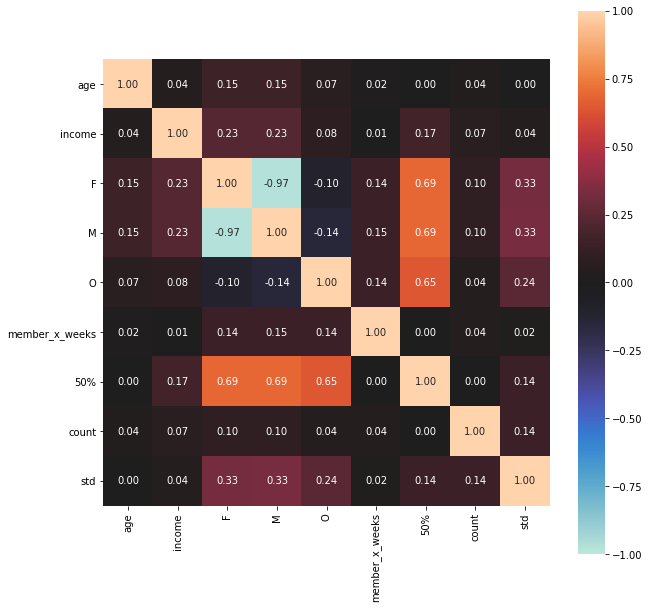

In [31]:
from dython.model_utils import roc_graph
from dython.nominal import associations

def associations_example():
    associations(Data_Correlation, nominal_columns=['age','member_x_weeks', 'income', '50%', 'count', 'std'])
    
    
# data correlation analyzis:


Data_Correlation=profiles_normalized.loc[:, ['age', 'income', 'F', 'M', 'O', 'member_x_weeks', '50%', 'count', 'std']]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10, 10
associations_example()

In [32]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [33]:
Data = profiles_normalized [['member_x_weeks', 'income', 'age', '50%', 'count', 'std']]

#Use a random sample of Data for faster computation
#Resetting the indexs
Data=Data.reset_index(drop=True)
#Rename the levels within in the CancellationCode column

Data.columns

#Checking whether data can be clustered
Num_features =Data.select_dtypes(include=[np.number]).columns
hopkins(Data[Num_features])

0.9107022490312486

Hopkins Value is signalizing that the Data is not randomly spread,
and is likely to be clustered

Using the Principal Components Analyzes:

In [34]:
from sklearn.decomposition import PCA

cols = ['age', 'income', 'member_x_weeks', '50%', 'count', 'std']

Data_pca= profiles_normalized [cols]
print (Data_pca.dtypes)

#Principal Component

pca = PCA(n_components= 'mle', whiten=True)

Num_features=Data_pca.select_dtypes(include=[np.number]).columns

x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

age               float64
income            float64
member_x_weeks    float64
50%               float64
count             float64
std               float64
dtype: object
[0.7135251647595536, 0.9684986077051903, 0.9986000103908103, 0.9991773235098838, 0.999732623820703]


In [35]:
#Principal Components converted to a Data frame


principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])
principalDf.shape


profiles_pca = pd.concat ([principalDf, profiles_normalized.reset_index()[['F', 'M', 'O', 'index']]], axis = 1)

profiles_pca['F'] = profiles_pca['F'].astype (int)
profiles_pca['M'] = profiles_pca['M'].astype (int)
profiles_pca['O'] = profiles_pca['O'].astype (int)

<function matplotlib.pyplot.show(*args, **kw)>

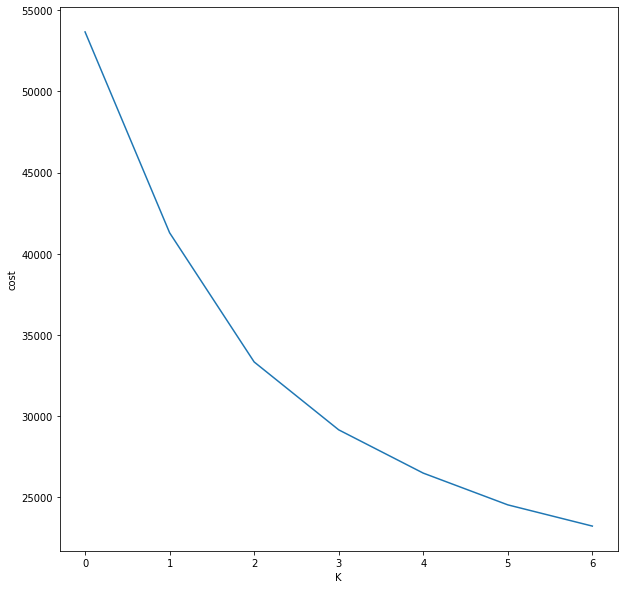

In [193]:
# Attention -- time consuming calculation

from kmodes.kprototypes import KPrototypes

#Choosing optimal K value
cost = []
X = profiles_pca[['principal component 1', 'principal component 2',
                  'principal component 3', 'principal component 4', 'principal component 5',
                  'F', 'M', 'O']]

for num_clusters in list(range(2,16, 2)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[5, 6, 7])
    cost.append(kproto.cost_)

<function matplotlib.pyplot.show(*args, **kw)>

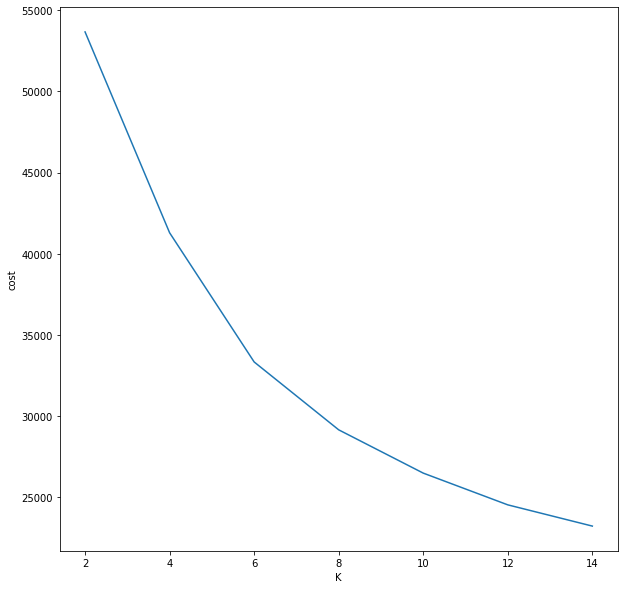

In [196]:
'''
    Plot the Cost Function for the Elbow Method
'''

cost_func = pd.DataFrame (cost, index = range(2,16, 2))
plt.plot(cost_func)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [36]:
'''
    Train Test Split:
    
    Random Split of the Profiles,
    'train' group is used to train the clustering algorithm,
    'test' group will only be predicted. 
    
    So If I get a similar (r2-value) picture on behavior (answers/reactions on offers),
    I can predict 'new' users (well with total new users facing a black-start problem)
'''

data = profiles_pca

from sklearn.model_selection import train_test_split


x_train, x_test = train_test_split(data,test_size=0.3) 

7    1658
2    1127
3    1082
5    1012
1     984
6     890
0     872
4     650
Name: Cluster_id, dtype: int64


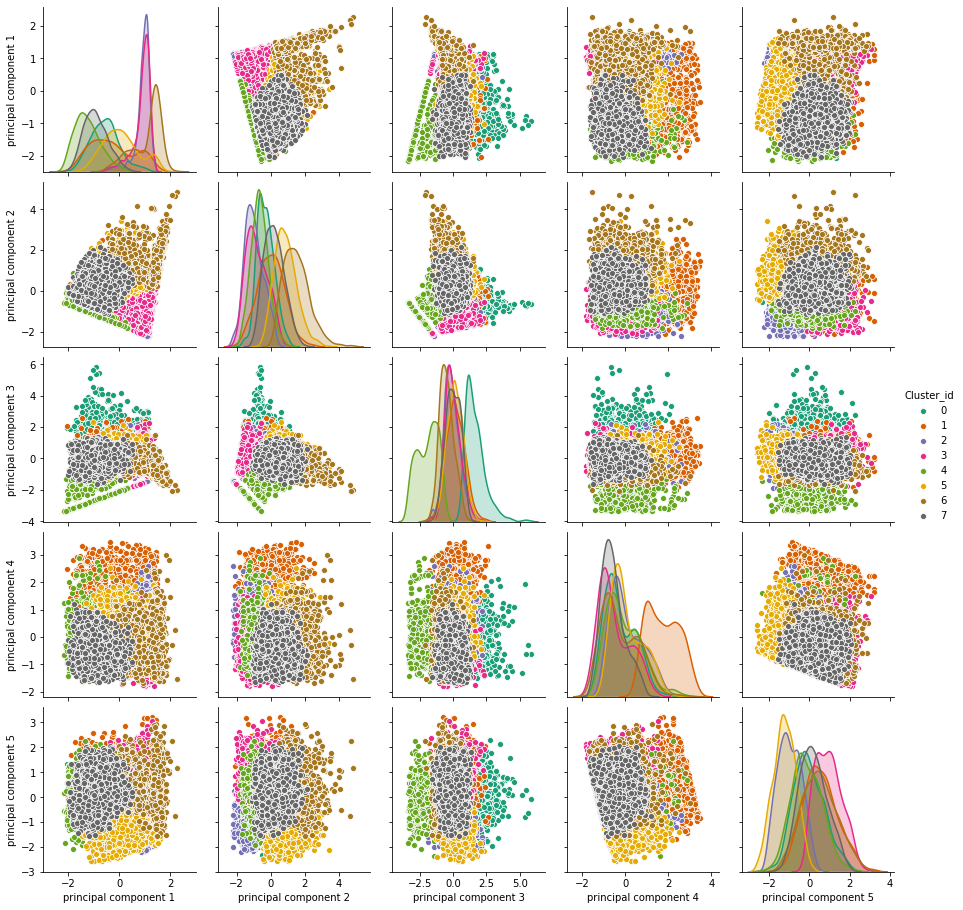

In [256]:
'''
    kModes / kPrototypes Clustering:
    
    kPrototypes Clustering algorithm can handle Categorical and Numerical columns at once.
    Well we can argue if there is a need on writing the genders col as categorical
        You could thing about it like Male yes/no so Male 1 - Female 0, 
        and Others would somehow be 0.5 (in between). So you can use the kMeans Clustering (only numerical) for example.
        
'''

from kmodes.kprototypes import KPrototypes

# number of clusters
k = 8

kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.25) 
clusters = kproto.fit_predict(x_train[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 
                                 'F', 'M', 'O']], 
                              categorical =[5, 6, 7])

df=pd.DataFrame(x_train)
df['Cluster_id']=clusters
clustering = df [['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5',  'Cluster_id']]
print(df['Cluster_id'].value_counts())
sns.pairplot(clustering,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [257]:
'''
    Add an other col, to split train and test group.
    
    test = 1
    train = 0
'''

clustering ['train_test'] = np.zeros (len (clustering))
clustering

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Cluster_id,train_test
4631,-0.276831,0.100059,-0.328508,0.578819,1.326488,1,0.0
1810,1.211844,-0.689513,-0.731171,1.045066,-1.264600,2,0.0
11503,-0.910714,0.444536,0.045979,0.028975,-0.332472,7,0.0
234,1.192888,0.666370,0.259331,1.540815,-0.911758,5,0.0
8947,-1.133923,-0.072142,0.593532,3.182056,0.040158,1,0.0
...,...,...,...,...,...,...,...
8028,1.511044,1.334564,-0.747002,-0.723012,-1.839621,5,0.0
4351,0.097412,-0.051996,0.765489,-0.086721,-1.243740,5,0.0
1462,-0.154671,-0.825228,-0.069323,-0.623550,-1.830642,2,0.0
9960,-1.108517,-0.100440,0.215479,0.744770,0.731753,7,0.0


7    729
3    488
2    481
1    429
5    408
6    373
0    348
4    291
Name: Cluster_id, dtype: int64


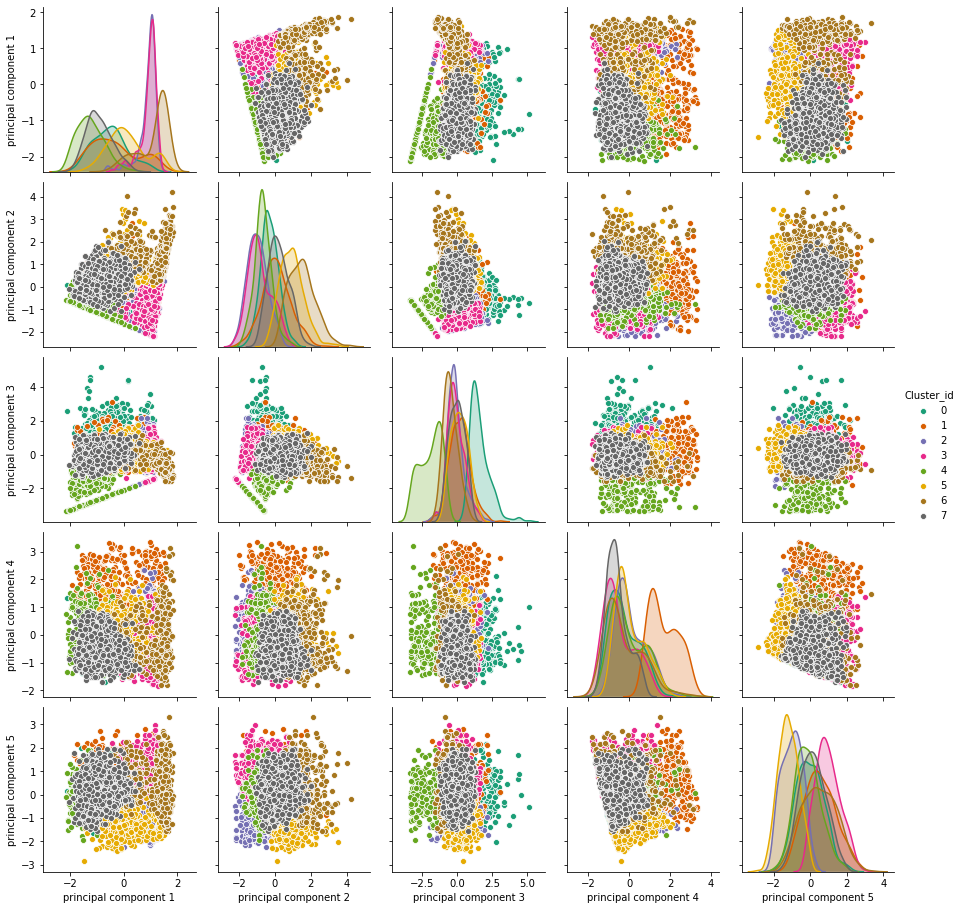

In [258]:
'''
    predicting the test clusters
'''

clusters = kproto.predict(x_test[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5',
                                 'F', 'M', 'O']], 
                              categorical =[5, 6, 7])

df=pd.DataFrame(x_test)
df['Cluster_id']=clusters
clustering_test = df [['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'Cluster_id']]
print(df['Cluster_id'].value_counts())
sns.pairplot(clustering_test,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [259]:
'''
    add the 'split' column
    test = 1
'''
clustering_test['train_test'] = np.ones (len (clustering_test))
clustering_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Cluster_id,train_test
11582,1.120903,-0.587268,0.713955,-0.829009,0.204340,3,1.0
6208,-0.706087,-0.077446,0.574392,1.227926,-0.811001,1,1.0
6106,-1.754051,-0.527405,-2.598069,-0.723925,0.995043,4,1.0
3679,-0.281502,1.007915,0.527010,0.530474,-0.136637,5,1.0
5330,0.673930,-1.694954,-0.112188,0.435030,0.825501,3,1.0
...,...,...,...,...,...,...,...
7444,-0.803406,-0.621753,2.129324,-0.614685,0.494558,0,1.0
11432,1.089313,0.039817,-0.422283,0.323093,-1.204055,2,1.0
6341,-0.945208,1.776564,0.206510,-1.069935,1.075417,7,1.0
4277,1.442319,1.174592,-0.161139,1.953387,-0.085962,1,1.0


In [260]:
'''
    combine test and train data
    
    &
    
    add the clusters to the profiles df
'''

clustering = clustering.append (clustering_test)

profiles = profile.merge (clustering, left_index = True, right_index = True)

In [261]:
'''
    just take a look at the numerical columns and plot the Cost function
'''

from sklearn.cluster import KMeans

X = clustering_test[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5']]

K = []
while i < 100:
    a = KMeans(n_clusters=i, random_state=42).fit (X)
    K.append (a.score (X))
    i += 1
    

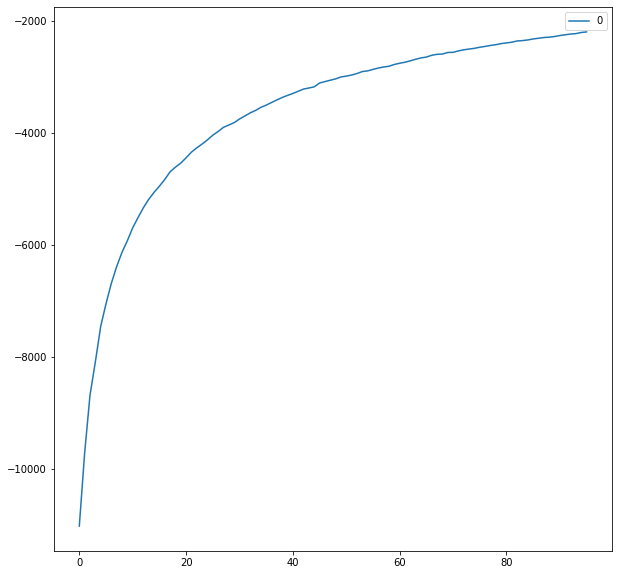

In [41]:
pd.DataFrame(K).plot ()

# x.2 Functions

In [262]:
def influence_scalar_to_binary (swell_value):
    
    '''
        Decide on what swell the transaction is called influenced
    '''

    i = 0

    influence_yn = []

    while i < len (influence_DF):
        if influence_DF.loc [i][0] >= swell_value:
            influence_yn.append (1)
        else:
            influence_yn.append (0)
        i += 1

    
    influence_bin = influence_DF.merge (pd.DataFrame(influence_yn), left_index = True, right_index = True)
    return influence_bin

In [263]:
def add_clusters (data):
    
    '''
        Add the found clusters to the transcript
        
        99 is the cluster for not indentified persons.
    '''
    
    i = 0
    cluster = []
    train_test = []
    stop = len (data)
    
    while i < stop:
        
        try: 
            cluster.append (profiles.set_index (['id']).loc [data.iloc [i]['person']] ['Cluster_id'])
            train_test.append (profiles.set_index (['id']).loc [data.iloc [i]['person']] ['train_test'])
        except: 
            cluster.append (99)
            train_test.append (99)
        
        i += 1
        print ('%.2f' % (i*100 / stop ), end = '\r')
    
    return cluster, train_test





# Choose a swell value!!

In [264]:
influence_DF = pd.DataFrame(scalar2)

In [265]:
'''
    Choosing a swell value for the scalar.
    
    I recommend swell value of 1
'''
swell_value = 1

influence_bin = influence_scalar_to_binary (swell_value)
influence_bin['index'] = influence_ind
influence_bin = influence_bin.set_index ('index')

In [266]:
transcript3 = transcript2.merge (influence_bin, left_index = True, right_index = True, how = 'left')
transcript3.rename (columns = {0: 'influence bin'}, inplace = True)
transcript3['influence bin'].value_counts()

1.0    21830
0.0    11515
Name: influence bin, dtype: int64

# Add Clusters to the trancsript values

In [267]:
received, viewed, completed, transactions = split_on_event (transcript3)

In [268]:
transactions1 = add_clusters (transactions)

print ('clusters for the transactions determined')

received1  = add_clusters (received)

print ('clusters for the offers sent determined')

clusters for the transactions determined
clusters for the offers sent determined


In [269]:
# add clusters  
analyzes_DF = transactions.reset_index().merge (pd.DataFrame (transactions1).T, left_index = True, right_index = True)


received_a = received.reset_index().merge (pd.DataFrame (received1).T, left_index = True, right_index = True)


analyzes_DF.rename (columns = {0: 'cluster', 1:'train_test'}, inplace = True)
received_a.rename (columns = {0: 'cluster', 1:'train_test'}, inplace = True)

In [270]:
analyzes_DF['cluster'].value_counts()

99.0    34221
6.0     23920
7.0     19971
5.0     19425
1.0     12714
3.0     11534
2.0     10936
0.0      8635
4.0      3994
Name: cluster, dtype: int64

# Start of Evaluation

In [271]:
'''
    Train Test split based on the split of the clusters Profile

'''

received_test = received_a [received_a ['train_test'] == 1]
received_train = received_a [received_a ['train_test'] == 0]

# drop duplicates in the transcript df.
analyzes_DF = analyzes_DF[analyzes_DF ['index'].duplicated () == False]

analyzes_DF_train = analyzes_DF [analyzes_DF ['train_test'] == 0]
analyzes_DF_test = analyzes_DF [analyzes_DF ['train_test'] == 1]

In [297]:
def  get_cluster_desc  (cluster, offer_id, data, data_received):
    
    
    DF = data [data ['cluster']== cluster] [
           data [data ['cluster']== cluster]['completed_yn'] == 1]
    

    
    offer_infl = DF[DF ['offer_id_y'] == offer_id][
             DF[DF['offer_id_y'] == offer_id]['influence bin'] ==1
             ]['amount'].describe()
    
    offer_noinfl = DF[DF ['offer_id_y'] == offer_id][
             DF[DF['offer_id_y'] == offer_id]['influence bin'] == 0 
             ]['amount'].describe()

  

    '''
        unknown completion 
    '''
    
    DF = data [data ['cluster']== cluster] [
           data [data ['cluster']== cluster]['completed_yn_unknown'] == 1]
    
    
    count_off = data_received[data_received.offer_id_x == offer_id][
                    data_received[data_received.offer_id_x == offer_id]['cluster'] == cluster
                                                   ]['DayOfMonth'].describe ()
    
    
    offer_unsucc = DF[DF ['offer_id_y'] == offer_id]['amount'].describe()
    
    
    vect = pd.DataFrame ([offer_infl, offer_noinfl, offer_unsucc, count_off])
    vect_names = pd.DataFrame(['offer_infl', 'offer_noinfl', 'offer_unsucc', 'count_off'])
    vect.index = vect_names [0]
    
    return vect
    
    
def get_cluster_offer (offer_id):
    
    data = analyzes_DF_train
    received_data = received_train
      
    data_train = []
    i = 0
    while i < k:
        cluster = i
        data_train.append (get_cluster_desc (cluster, offer_id, data, received_data)['count'])
        i += 1
    data_train = pd.DataFrame (data_train, index = np.arange (k))
    
    data = analyzes_DF_test
    received_data = received_test
            
    data_test = []
    i = 0
    while i < k:
        cluster = i
        data_test.append (get_cluster_desc (cluster, offer_id, data, received_data)['count'])
        i += 1
    data_test = pd.DataFrame (data_test, index = np.arange (k))
    
    return data_train, data_test

In [384]:
'''
    Checking one Cluster and one Offer
    
'''

cluster = 3
offer_id = 'ae264e3637204a6fb9bb56bc8210ddfd'
data = analyzes_DF_test
received_data = received_test

get_cluster_desc (cluster, offer_id, data, received_data)['count']

0
offer_infl       13.0
offer_noinfl      2.0
offer_unsucc      0.0
count_off       207.0
Name: count, dtype: float64

# Model performance

remember I have the train test split data on the clusters.
I will now Perform the evaluation again.

In [381]:

def get_proportions (offer_list):
    

    c = []
    df_train_abs = pd.DataFrame (np.zeros((8, 4)), columns = {'offer_infl', 'offer_noinfl', 'offer_unsucc','count_off'})
    df_test_abs = pd.DataFrame (np.zeros((8, 4)), columns = {'offer_infl', 'offer_noinfl', 'offer_unsucc','count_off'})

    for off_id in offer_list:
        offer_id = off_id
        data_train, data_test = get_cluster_offer (offer_id)
        
        df_train_abs += data_train
        df_test_abs += data_test

    df_train_count = df_train_abs['count_off']
    df_train_abs = df_train_abs.drop ('count_off', axis = 1)
    
    for col in list(df_train_abs.columns):
        df_train_abs[col] = df_train_abs [col]/  df_train_count
        
    df_train = df_train_abs.T.sort_index().T
    # df_train.plot (kind = 'bar', stacked = True, figsize=(5,5))
    
    df_test_count = df_test_abs ['count_off']
    df_test_abs = df_test_abs.drop ('count_off', axis = 1)
    
    for col in list(df_test_abs.columns):
        df_test_abs[col] = df_test_abs [col]/ df_test_count
        
    df_test = df_test_abs.T.sort_index().T
    # df_test.plot (kind = 'bar', stacked = True, figsize=(5,5))
    
    
    return df_train, df_test


# R Squared metric for each column! 
'''
    since I look at one cluster as a whole system 
    I do calculate regression-like values.
'''

from sklearn.metrics import r2_score

def get_rsquared_val (test1, train1, test2, train2):



    rsquared = []
    cols = []
    test = test1. append (test2)
    train = train1.append (train2)
    
    for col in test.columns:
        y_pred = test [col]
        y_true = train [col]
        cols.append (col)
        rsquared.append (r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average'))
    rsquared = pd.DataFrame (rsquared, index = cols)
    
    print (rsquared)
    return rsquared

def get_plot (data1, data2, title):
    x = np.arange(len(data1.index))  # the label locations
    width = 0.33  # the width of the bars

    ind = data1.index

    p1 = plt.bar((ind - width/2), data1['offer_infl'], width, color = 'green')
    p2 = plt.bar((ind - width/2), data1['offer_noinfl'], width,
                                 bottom=data1['offer_infl'], color = 'darkorange')
    p3 = plt.bar ((ind - width/2), data1['offer_unsucc'], width,
             bottom=data1['offer_infl']+data1['offer_noinfl'], color = 'darkred')


    p4 = plt.bar((ind + width/2), data2['offer_infl'], width, color = 'limegreen')
    p5 = plt.bar((ind + width/2), data2['offer_noinfl'], width,
                                 bottom=data2['offer_infl'], color = 'lemonchiffon')
    p6 = plt.bar ((ind + width/2), data2['offer_unsucc'], width,
             bottom=data2['offer_infl']+data2['offer_noinfl'], color = 'red')

    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(ind, (data1.index))
    plt.grid(color='black', linestyle='-', linewidth=1, axis = 'y')
    plt.yticks(np.arange(0, 1, 0.1))
    plt.legend((p1[0], p2[0], p3[0]), ('influenced', 'not influenced', 'unsuccessful'))
    plt.figure (figsize=(15, 10))
    plt.show()

    return 

In [299]:
Offer_list2

4    0b1e1539f2cc45b7b9fa7c272da2e1d7
5    2298d6c36e964ae4a3e7e9706d1fb8c2
6    fafdcd668e3743c1bb461111dcafc2a4
9    2906b810c7d4411798c6938adc9daaa5
Name: id, dtype: object

In [300]:
portfolio

,index,reward,difficulty,duration,offer_type,id,durationHOURS,email,mobile,social,web
0,0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1,1,1,0
1,1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1,1,1,1
2,2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,96,1,1,0,1
3,3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1,1,0,1
4,4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,1,0,0,1
5,5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168,1,1,1,1
6,6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240,1,1,1,1
7,7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72,1,1,1,0
8,8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1,1,1,1
9,9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,168,1,1,0,1


                     0
offer_infl    0.994837
offer_noinfl  0.940593
offer_unsucc  0.868981


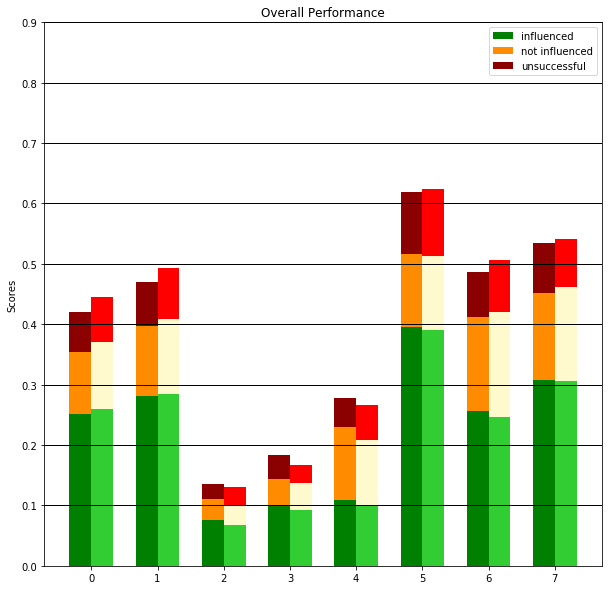

<Figure size 1080x720 with 0 Axes>

,offer_infl,offer_noinfl,offer_unsucc
0,0.250728,0.102727,0.066720
1,0.280682,0.116136,0.072273
2,0.075035,0.035287,0.024539
3,0.100844,0.042827,0.040295
4,0.108118,0.122297,0.047855
5,0.395494,0.119957,0.103219
6,0.256881,0.155022,0.075041
7,0.307856,0.144341,0.082557


In [390]:
'''
    Overall Performance each cluster

'''

Offer_list1 = portfolio ['id']
df_train1, df_test1 = get_proportions (Offer_list1)

OverallPerformance = df_train1
test1 = df_test1

rsquared = []
cols = []

## R-Squared for each 'group'
for col in test1.columns:
    y_pred = test1 [col]
    y_true = OverallPerformance [col]
    cols.append (col)
    rsquared.append (r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average'))
rsquared = pd.DataFrame (rsquared, index = cols)
    
print (rsquared)

get_plot (OverallPerformance, test1, 'Overall Performance')
OverallPerformance

                     0
offer_infl    0.985676
offer_noinfl  0.932672
offer_unsucc  0.850522


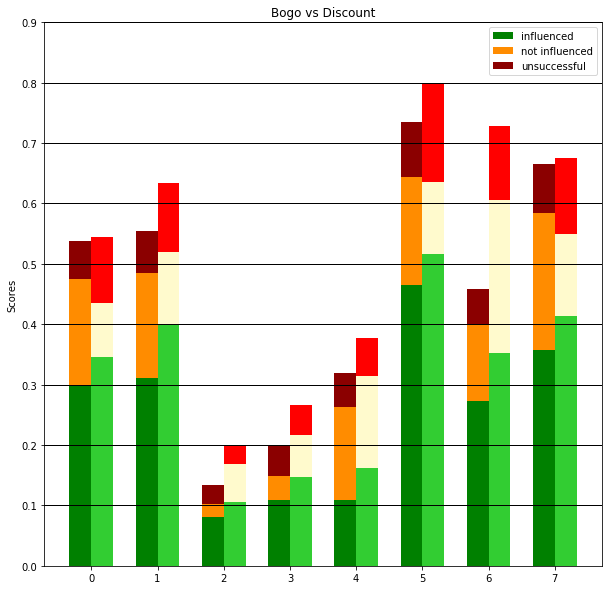

<Figure size 1080x720 with 0 Axes>

In [404]:
'''
    Split the Offers into two sets (Offer_list1 & 2)
    
    Bogo vs Discount
'''

# Offer_list1: 
Offer_list1 = portfolio[portfolio ['offer_type'] == 'bogo']['id']

# Offer_list2:
Offer_list2 = portfolio[portfolio ['offer_type'] == 'discount']['id']



df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

df_bogo_train = df_train1
df_bogo_test = df_test1
df_disc_train = df_train2
df_disc_test = df_test2

r2_off_type = get_rsquared_val (df_bogo_test, df_bogo_train, df_disc_test, df_disc_train)


get_plot (df_bogo_train, df_disc_train, 'Bogo vs Discount')



                     0
offer_infl    0.956239
offer_noinfl  0.905218
offer_unsucc  0.934766


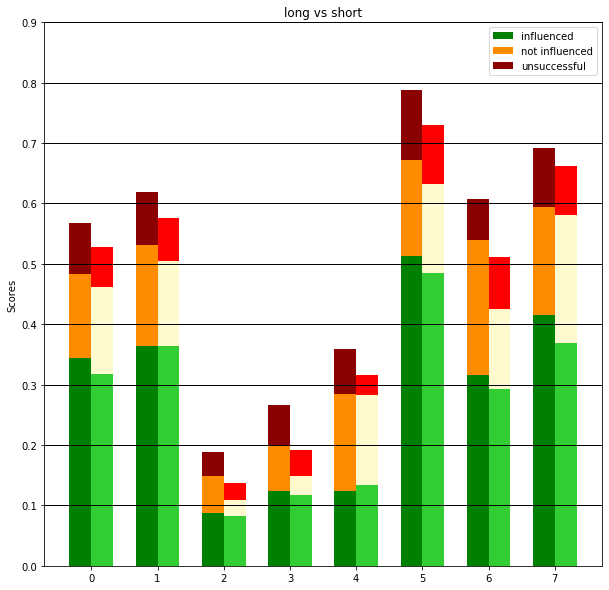

<Figure size 1080x720 with 0 Axes>

In [405]:
'''
    Split the Offers into two sets (Offer_list1 & 2)
    
    Duration list1 = long
'''

# Offer_list1: 
Offer_list1 = ['ae264e3637204a6fb9bb56bc8210ddfd', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
              'fafdcd668e3743c1bb461111dcafc2a4']

# Offer_list2:
Offer_list2 = ['4d5c57ea9a6940dd891ad53e9dbe8da0', 'f19421c1d4aa40978ebb69ca19b0e20d',
              '2906b810c7d4411798c6938adc9daaa5']




df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

df_long_train = df_train1
df_long_test = df_test1
df_short_train = df_train2
df_short_test = df_test2

r2_duration = get_rsquared_val (test1, train1, test2, train2)


get_plot (df_long_train, df_short_train, 'long vs short')


                     0
offer_infl    0.985518
offer_noinfl  0.910306
offer_unsucc  0.919553


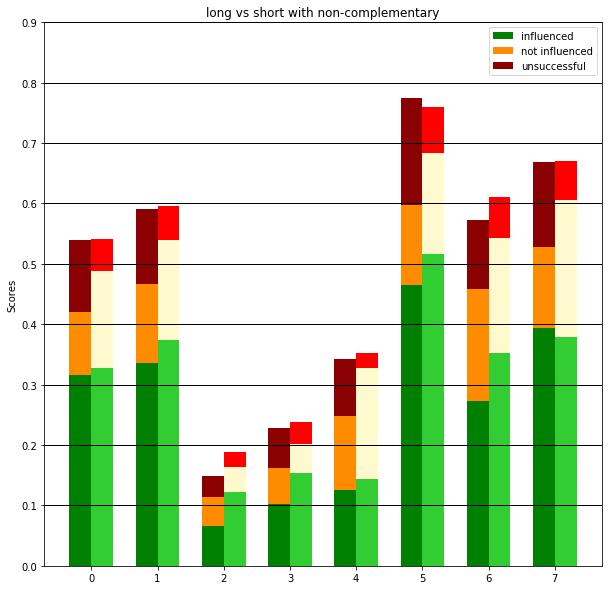

<Figure size 1080x720 with 0 Axes>

In [407]:
'''
    Split the Offers into two sets (Offer_list1 & 2)
    
    Duration list1 = long
    with the additional non complementary Offers.
'''

# Offer_list1: 
Offer_list1 = ['ae264e3637204a6fb9bb56bc8210ddfd', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
              'fafdcd668e3743c1bb461111dcafc2a4', '0b1e1539f2cc45b7b9fa7c272da2e1d7']

# Offer_list2:
Offer_list2 = ['4d5c57ea9a6940dd891ad53e9dbe8da0', 'f19421c1d4aa40978ebb69ca19b0e20d',
              '2906b810c7d4411798c6938adc9daaa5', '2298d6c36e964ae4a3e7e9706d1fb8c2']



df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

df_long2_train = df_train1
df_long2_test = df_test1
df_short2_train = df_train2
df_short2_test = df_test2

r2_duration2 = get_rsquared_val (df_long2_test, df_long2_train, df_short2_test, df_short2_train)


get_plot (df_long2_train, df_short2_train, 'long vs short with non-complementary')


                     0
offer_infl    0.976813
offer_noinfl  0.972413
offer_unsucc  0.824950


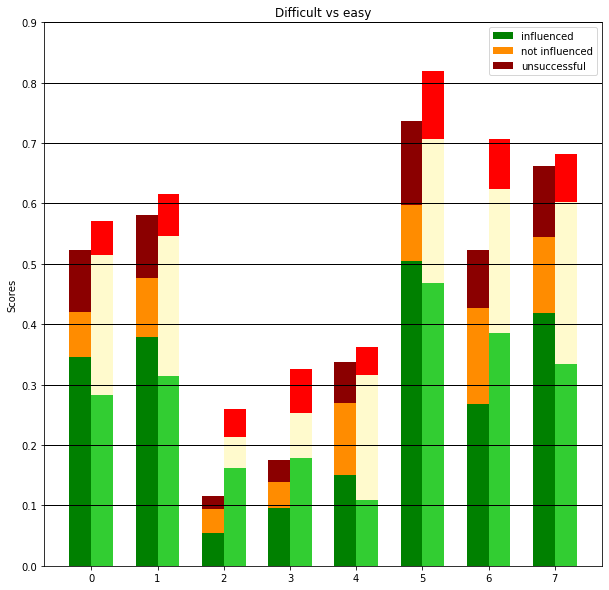

<Figure size 1080x720 with 0 Axes>

In [408]:
'''
    Split the Offers into two sets (Offer_list1 & 2)
    
    Duration list1 = difficult
'''


# Offer_list1: 
Offer_list1 = ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0',
              '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']

# Offer_list2:
Offer_list2 = ['9b98b8c7a33c4b65b9aebfe6a799e6d9', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'f19421c1d4aa40978ebb69ca19b0e20d']


df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

df_diff_train = df_train1
df_diff_test = df_test1
df_eas_train = df_train2
df_eas_test = df_test2

r2_diff = get_rsquared_val (df_diff_test, df_diff_train, df_eas_test, df_eas_train)


get_plot (df_diff_train, df_eas_train, 'Difficult vs easy')

In [418]:
''' 
    R Squared Scores
'''

r2 = r2_off_type.T.append (r2_duration.T).append (r2_diff.T)
r2.index =['offer type', 'duration', 'difficulty'] 
r2

,offer_infl,offer_noinfl,offer_unsucc
offer type,0.985676,0.932672,0.850522
duration,0.956239,0.905218,0.934766
difficulty,0.976813,0.972413,0.824950


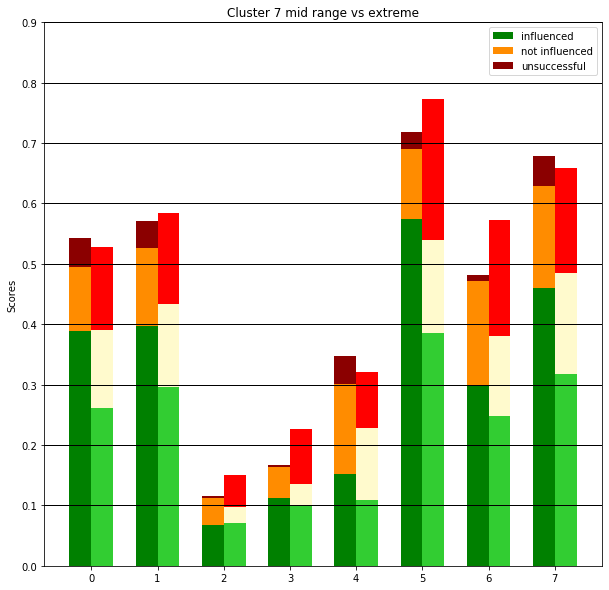

<Figure size 1080x720 with 0 Axes>

                       0
offer_infl      0.941589
offer_noinfl -251.140639
offer_unsucc    0.954110


In [472]:
'''
    Cluster 7 
    
    both types mid range
'''

# Offer_list1: 
Offer_list1 = ['ae264e3637204a6fb9bb56bc8210ddfd', 'fafdcd668e3743c1bb461111dcafc2a4',
               '4d5c57ea9a6940dd891ad53e9dbe8da0', 'ae264e3637204a6fb9bb56bc8210ddfd']

# Offer_list2:
Offer_list2 = ['9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d', 
               '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2906b810c7d4411798c6938adc9daaa5']



df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

train1 = df_train1
test1 = df_test1
train2 = df_train2
test2 = df_test2

get_plot (train1, train2, 'Cluster 7 mid range vs extreme')


test1 = pd.DataFrame(test1.loc [7]).T
train1 =  pd.DataFrame(train1.loc [7]).T
test2 = pd.DataFrame(test2.loc [7]).T
train2 = pd.DataFrame(train2.loc [7]).T

r2_Cluster7 = get_rsquared_val (test1, train1, test2, train2)

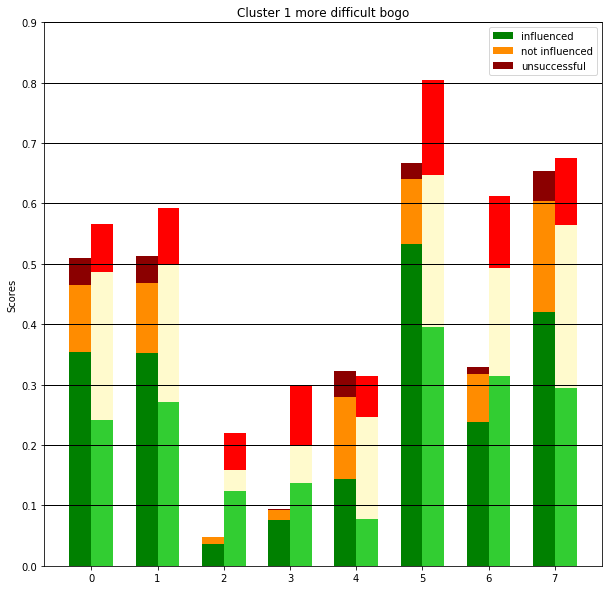

<Figure size 1080x720 with 0 Axes>

                     0
offer_infl    0.299545
offer_noinfl  0.938327
offer_unsucc  0.917182


In [476]:
'''
    Cluster 1
    
    more diff BOGO
'''

# Offer_list1: 
Offer_list1 = portfolio [portfolio ['offer_type'] == 'bogo'].sort_values ('difficulty')[2:4]['id']
    # ascending = True therefor the latter 2!

# Offer_list2:
Offer_list2 = portfolio [portfolio ['offer_type'] == 'bogo'].sort_values ('difficulty')[0:2]['id']



df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

train1 = df_train1
test1 = df_test1
train2 = df_train2
test2 = df_test2



get_plot (train1, train2, 'Cluster 1 more difficult bogo')

test1 = pd.DataFrame(test1.loc [1]).T
train1 =  pd.DataFrame(train1.loc [1]).T
test2 = pd.DataFrame(test2.loc [1]).T
train2 = pd.DataFrame(train2.loc [1]).T

r2_Cluster1 = get_rsquared_val (test1, train1, test2, train2)

In [477]:
portfolio [portfolio ['offer_type'] == 'bogo'].sort_values ('difficulty')[0:2]

,index,reward,difficulty,duration,offer_type,id,durationHOURS,email,mobile,social,web
3,3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1,1,0,1
8,8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1,1,1,1


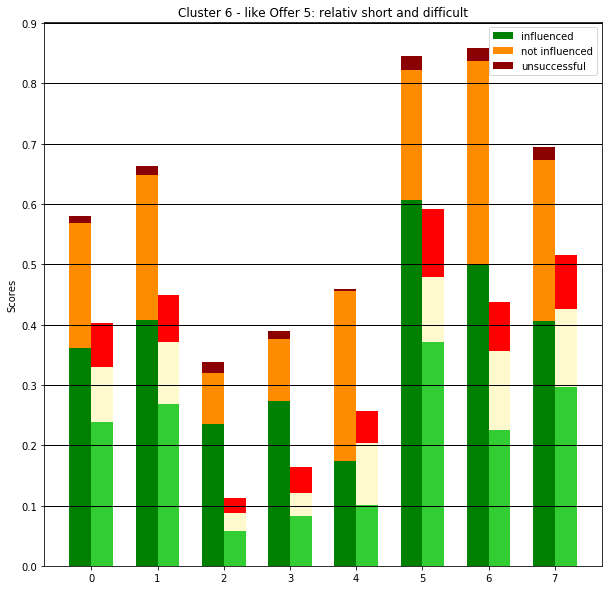

<Figure size 1080x720 with 0 Axes>

                     0
offer_infl    0.981540
offer_noinfl  0.957267
offer_unsucc  0.723097


In [478]:
'''
    Cluster 6
    
    like the offer number 5
'''

# Offer_list1: 
Offer_list1 = [portfolio.loc[5]['id']]
    # just add the square brackets, so no error occurs

# Offer_list2:
Offer_list2 = portfolio.drop ([5], axis = 0)['id']


df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

train1 = df_train1
test1 = df_test1
train2 = df_train2
test2 = df_test2


get_plot (train1, train2, 'Cluster 6 - like Offer 5: relativ short and difficult')


test1 = pd.DataFrame(test1.loc [6]).T
train1 =  pd.DataFrame(train1.loc [6]).T
test2 = pd.DataFrame(test2.loc [6]).T
train2 = pd.DataFrame(train2.loc [6]).T

r2_Cluster6 = get_rsquared_val (test1, train1, test2, train2)

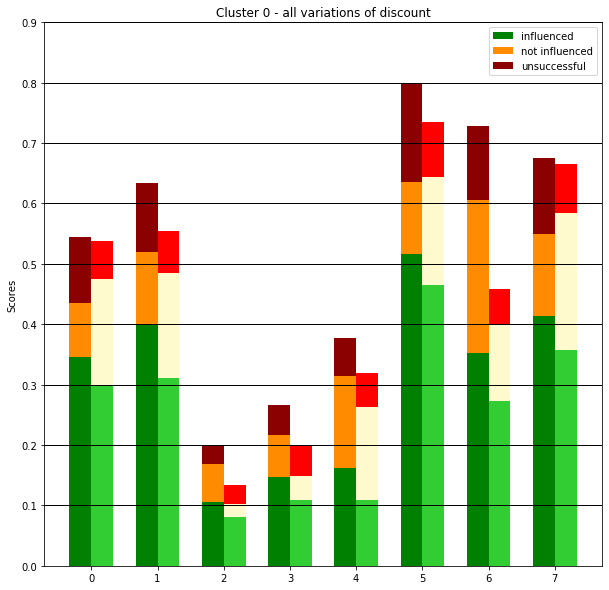

<Figure size 1080x720 with 0 Axes>

                     0
offer_infl    0.889349
offer_noinfl  0.930272
offer_unsucc  0.635417


In [479]:
'''
    Cluster 0
    
    all variations of discount
'''

# Offer_list1: 
Offer_list1 = portfolio[portfolio ['offer_type'] == 'discount']['id']
    # just add the square brackets, so no error occurs

# Offer_list2:
Offer_list2 = portfolio[portfolio ['offer_type'] == 'bogo']['id']


df_train1, df_test1 = get_proportions (Offer_list1)
df_train2, df_test2 = get_proportions (Offer_list2)

train1 = df_train1
test1 = df_test1
train2 = df_train2
test2 = df_test2


get_plot (train1, train2, 'Cluster 0 - all variations of discount')

test1 = pd.DataFrame(test1.loc [0]).T
train1 =  pd.DataFrame(train1.loc [0]).T
test2 = pd.DataFrame(test2.loc [0]).T
train2 = pd.DataFrame(train2.loc [0]).T

r2_Cluster0 = get_rsquared_val (test1, train1, test2, train2)

In [483]:
r2_recoomendations = r2_Cluster7.T. append (r2_Cluster1.T).append (r2_Cluster6.T).append (r2_Cluster0.T)
r2_recoomendations.index = ['Cluster7', 'Cluster1', 'Cluster6', 'Cluster0']
r2_recoomendations

,offer_infl,offer_noinfl,offer_unsucc
Cluster7,0.889349,0.930272,0.635417
Cluster1,0.299545,0.938327,0.917182
Cluster6,0.981540,0.957267,0.723097
Cluster0,0.889349,0.930272,0.635417
